 # <font color = #254117>[EEP 147]: ESG Analysis Lecture Graphs</font>

<div style="width:image width px; font-size:80%; text-align:center;"><img src="big_creek.jpg" alt="alternate text" width="500" height="height" style="padding-bottom:0.5em;" />Big Creek Hydroelectric Project - Southern California Edison</div>

This notebook can be utilized for analysis of the Electricity Strategy Game. This notebook builds on the Round 0 notebook by allowing carbon prices to be adjusted in more of the function, including separately for each of Rounds 4, 5, and 6 in the NPV of expected profits function.

First on our agenda is to import **<font color = ##008700>dependencies</font>** -- packages in Python that add to the basic functions in Python -- same as before.

In [25]:
from datascience import *
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
%matplotlib inline
import numpy as np
import pandas as pd
from ipywidgets import interact, interactive, Dropdown, IntSlider
import ipywidgets as widgets
from functools import partial
from matplotlib.lines import Line2D
plt.style.use('fivethirtyeight')
plt.rcParams["figure.figsize"] = [10,6]

Next, let's select your portfolio. In the cell below, assign **section** to the section code (including quotes) that corresponds to your own according to the following table.

| Code | Section Time  |
|---------|---------------|
| "W9" | Wednesday 9am|
| "T1" | Thursday 4pm - Aaron, Room 130|
| "T2" | Thursday 4pm - Max, Room 220|

The variable **current_period** should contain the current round.

The variable **pab_periods** should contain each of the periods for which there was or will be a pay-as-bid auction.  This shouldn't change.

In [26]:
SECTIONS = ['W9','T1','T2']
section = "W9"
period = 2
#leave current period - it works with some of the functions
current_period = period+1
pab_periods = [1]

Next we import the demand forecasts.

In [27]:
demand_table = Table.read_table('demand.csv')

Next we import our Bids and Porfolios tables.

In [28]:
bids_mc = Table.read_table('Bids/MC_bids.csv').sort('PORTFOLIO')
ESG = Table.read_table('ESGPorfolios.csv')

In the following cell we will join the tables based on the column **Plant_ID**.  We will incorporate the actual bids of the rounds completed.

In [29]:
def get_bids(section):
    bids_all = bids_mc.copy()
    bids_all_df = bids_all.sort("PLANT_ID").to_df()
    bids_actual = Table.read_table('Bids/' + section + '_bids_' + str(current_period - 1) + '.csv').sort('PORTFOLIO')
    bids_actual_df = bids_actual.sort("PLANT_ID").to_df()
    if current_period > 1:
        for period_i in range(1,current_period):
            bids_all_df.loc[bids_all_df["PERIOD"] == period_i] = bids_actual_df.loc[bids_actual_df["PERIOD"] == period_i].values
        bids_all = Table.from_df(bids_all_df)
    else:
        bids_all_df.loc[bids_all_df["PERIOD"] == 0] = bids_actual_df.loc[bids_actual_df["PERIOD"] == 0].values
        bids_all = Table.from_df(bids_all_df)
        
    joined_table_all = bids_all.join("PLANT_ID", ESG, "Plant_ID").sort("PLANT_ID")
    return(joined_table_all)

if period < 7:
    joined_table_all = get_bids(section)

In [30]:
bids_all = bids_mc.copy()
bids_all_df = bids_all.sort("PLANT_ID").to_df()
bids_actual = Table.read_table('Bids/' + section + '_bids_' + str(current_period - 1) + '.csv').sort('PORTFOLIO')
bids_actual_df = bids_actual.sort("PLANT_ID").to_df()

Define helper functions

In [31]:
energy_colors_dict = {'Bay Views' : '#EC5F67', 'Beachfront' : '#F29056', 'Big Coal' : '#F9C863', 'Big Gas' : '#99C794', 
                      'East Bay' : '#5FB3B3', 'Fossil Light' : '#6699CC', 'Old Timers' : '#C594C5'}

def demand_calc(hour, period, demand_sp):
    demand = demand_table.where("round", period).where("hour", hour)["load"].item()
    if np.abs(demand_sp) <= 1:
        demand *= (1 + demand_sp)
    else:
        demand = demand_sp
    return(demand)

def price_calc(input_table, demand, hour, period):
    #hour and period determine which bids are taken from joined_table
    joined_table = input_table.copy()
    sorted_table = joined_table.where("PERIOD", period).sort("PRICE" + str(hour), descending = False)
    price = 0
    sum_cap = 0
    for i in range(0,len(sorted_table['Capacity_MW'])):
        if sum_cap + sorted_table['Capacity_MW'][i] >= demand:
            price = sorted_table['PRICE' + str(hour)][i]
            break
        else:
            sum_cap += sorted_table['Capacity_MW'][i]
            price = sorted_table['PRICE' + str(hour)][i]
    return price

def find_x_pos(widths):
    cumulative_widths = [0]
    cumulative_widths.extend(np.cumsum(widths))
    half_widths = [i/2 for i in widths]
    x_pos = []
    for i in range(0, len(half_widths)):
        x_pos.append(half_widths[i] + cumulative_widths[i])
    return x_pos

def price_line_plot(price):
    plt.axhline(y=price, color='r', linewidth = 2)
    
def demand_plot(demand):
    plt.axvline(x=demand, color='r', linewidth = 2)

def adjust_by_cp(input_table, hour, period, carbon_price):
    joined_table = input_table.copy()
    joined_table["Var_Cost_USDperMWH"] += carbon_price * joined_table["Carbon_tonsperMWH"]
    if (period >= current_period) | (current_period == 8):
        joined_table["PRICE" + str(hour)] += carbon_price * joined_table["Carbon_tonsperMWH"]
    return(joined_table)
    
def adjust_bids_by_cp(input_table, hour, period, carbon_price):
    joined_table = input_table.copy()
    joined_table["Var_Cost_USDperMWH"] += carbon_price * joined_table["Carbon_tonsperMWH"]
    joined_table["PRICE" + str(hour)] += carbon_price * joined_table["Carbon_tonsperMWH"]
    return(joined_table)
    
def user_defined_bids(input_table, hour, period, my_portfolio, def_my_bids, def_others_bids):
    joined_table = input_table.copy()
    joined_df = joined_table.to_df()
    if def_my_bids:
        joined_df.loc[(joined_df["Group"] == my_portfolio) & 
                      (joined_df["PERIOD"] == period), 
                      "PRICE" + str(hour)] =  list(globals()["bids_" + my_portfolio.replace(" ", "").lower()].values())
    if def_others_bids:
        for group in set(joined_table['Group']):
            if group != my_portfolio:
                joined_df.loc[(joined_df["Group"] == group) & 
                              (joined_df["PERIOD"] == period), 
                              "PRICE" + str(hour)] =  list(globals()["bids_" + group.replace(" ", "").lower()].values())
    joined_table = Table.from_df(joined_df)
    return(joined_table)

def market_plot(section, hour, period, carbon_price, my_portfolio, def_my_bids, def_others_bids):
    demand = demand_table.where("round", period).where("hour", hour)["load"].item()
    joined_table = get_bids(section)
    joined_table = adjust_by_cp(joined_table, hour, period, carbon_price)
    if period >= current_period:
        joined_table = adjust_bids_by_cp(joined_table, hour, period, carbon_price)
    joined_table = user_defined_bids(joined_table, hour, period, my_portfolio, def_my_bids, def_others_bids)
    
    sorted_joined_table = joined_table.where("PERIOD", period).sort("PRICE" + str(hour), descending = False)
    width = sorted_joined_table.column("Capacity_MW")
    height = sorted_joined_table.column('PRICE' + str(hour))
    x_vals = find_x_pos(width)
    colors_mapped = list(pd.Series(sorted_joined_table['Group']).map(energy_colors_dict))
    sorted_joined_table = sorted_joined_table.with_column('Color', colors_mapped)
    group_colors = sorted_joined_table.group("Group", lambda x: x).select("Group", "Color")
    group_colors["Color"] = group_colors.apply(lambda x: x[0], "Color")
    price = price_calc(sorted_joined_table, demand, hour, period)
    # Make the plot
    plt.figure(figsize=(9,6))
    plt.bar(x_vals, height, width=width, color=sorted_joined_table['Color'], edgecolor = "black")
    
    #add MC line
    num_plants = len(width)
    height_mc = sorted_joined_table.column("Var_Cost_USDperMWH")
    x_vec = np.zeros(num_plants * 2)
    h_vec = np.zeros(num_plants * 2)
    for i, (w, h) in enumerate(zip(width, height_mc)):
        h_vec[2*i] = h
        h_vec[2*i+1] = h
        if i == 0:
            x_vec[1] = w
        else: 
            x_vec[2*i] = x_vec[2*i - 1]
            x_vec[2*i + 1] = x_vec[2*i] + w
    #mc bars
    plt.bar(x_vals, height_mc, width=width, color=sorted_joined_table['Color'], edgecolor = "black", alpha=.2)
                   
    #x_vec = np.zeros(num_plants*2 + 2)
    #h_vec = np.zeros(num_plants*2 + 2)
    #for i, (w, h) in enumerate(zip(width, height_mc)):
    #    x_vec[2*i + 1] = x_vec[2*i]
    #    x_vec[2*i + 2] = x_vec[2*i + 1] + w
    #    h_vec[2*i + 1] = h
    #    h_vec[2*i + 2] = h
    #x_vec[-1] = x_vec[-2]
    
    if carbon_price > 0:
        line_mc = plt.plot(x_vec, h_vec, '--k', label='Marginal Cost\n(permit price ' + str(carbon_price) + ')', linewidth=2)
    else:
        line_mc = plt.plot(x_vec, h_vec, '--k', label='Marginal Cost', linewidth=2)
    
    patches = []
    for row in group_colors.rows:
        patches += [mpatches.Patch(color=row.item("Color"), label=row.item("Group"))]
    patches += line_mc
    plt.legend(handles=patches, bbox_to_anchor=(1.1,1))
    
    plt.title('Section ' + section + ', Round ' + str(period) + ', Hour ' + str(hour) + 
              '\ndemand = ' + str(round(demand,2)) + ', price = ' + str(price))
    plt.xlabel('Capacity_MW')
    plt.ylabel('Price')
    price_line_plot(price)
    demand_plot(demand)
    #plt.ylim((0, 100))

In [32]:
def emissions_calc(input_table, hour, period, demand, price, my_portfolio):    
    sorted_joined_table = input_table.copy()
    
    nonmarg_capacity = sum(sorted_joined_table.where('PRICE' + str(hour), are.below(price))["Capacity_MW"])
    marg_capacity = sum(sorted_joined_table.where('PRICE' + str(hour), are.equal_to(price))["Capacity_MW"])
    marg_demand = demand - nonmarg_capacity
    marg_proportion = marg_demand / marg_capacity
    
    sorted_table = sorted_joined_table.where("Group", my_portfolio)
    emissions = 0
    for i in range(len(sorted_table.where('PRICE' + str(hour), are.below(price))["Var_Cost_USDperMWH"])):
        emissions += sorted_table.where('PRICE' + str(hour), are.below(price))["Carbon_tonsperMWH"][i]\
        * sorted_table.where('PRICE' + str(hour), are.below(price))["Capacity_MW"][i]
    for i in range(len(sorted_table.where('PRICE' + str(hour), are.equal_to(price))["Var_Cost_USDperMWH"])):
        emissions += sorted_table.where('PRICE' + str(hour), are.equal_to(price))["Carbon_tonsperMWH"][i]\
        * (sorted_table.where('PRICE' + str(hour), are.equal_to(price))["Capacity_MW"][i] * marg_proportion)
    return emissions

In [33]:
def total_emissions(section, my_portfolio):
    portfolio_emissions_dict = {}
    if current_period > 1:
        joined_table = get_bids(section)
        portfolio_emissions = 0
        for period_i in range(1, current_period):        
            portfolio_emissions_period = 0
            
            for hour_i in range(1, 5):
                demand = demand_calc(hour_i, period_i, 0)
                sorted_joined_table = joined_table.where("PERIOD", period_i).sort("PRICE" + str(hour_i), descending = False)
                price = price_calc(sorted_joined_table, demand, hour_i, period_i)
                
                portfolio_emissions_period += emissions_calc(sorted_joined_table, hour_i, period_i, demand, price, my_portfolio)
                portfolio_emissions_dict['Round ' + str(period_i)] = portfolio_emissions_period
                    
            portfolio_emissions += portfolio_emissions_period
    else: 
        portfolio_emissions = 0
    portfolio_emissions_dict['Total'] = portfolio_emissions
    
    output_df = pd.DataFrame.from_dict(portfolio_emissions_dict, 
                                       orient = 'index', columns = [my_portfolio + ' Emissions']).round().astype(int)
    
    return output_df

In [34]:
#create table of Rounds 1-3 emissions in Round 4
emissions_df = pd.DataFrame()
section_col = []
portfolio_col = []
emissions_col = []
round1_col = []
round2_col = []
round3_col = []

if current_period == 4:
    for section in SECTIONS:
        for portfolio in np.unique(ESG["Group"]):
            emissions_df_portfolio = total_emissions(section, portfolio)
            section_col.append(section)
            portfolio_col.append(portfolio)
            emissions_col.append(emissions_df_portfolio.loc['Total'][0])
            round1_col.append(emissions_df_portfolio.loc['Round 1'][0])
            round2_col.append(emissions_df_portfolio.loc['Round 2'][0])
            round3_col.append(emissions_df_portfolio.loc['Round 3'][0])
            
emissions_df['Section'] = section_col
emissions_df['Portfolio'] = portfolio_col
emissions_df['Emissions'] = emissions_col
emissions_df['Round1'] = round1_col
emissions_df['Round2'] = round2_col
emissions_df['Round3'] = round3_col

emissions_df.to_csv('emissions_123.csv', index=False)

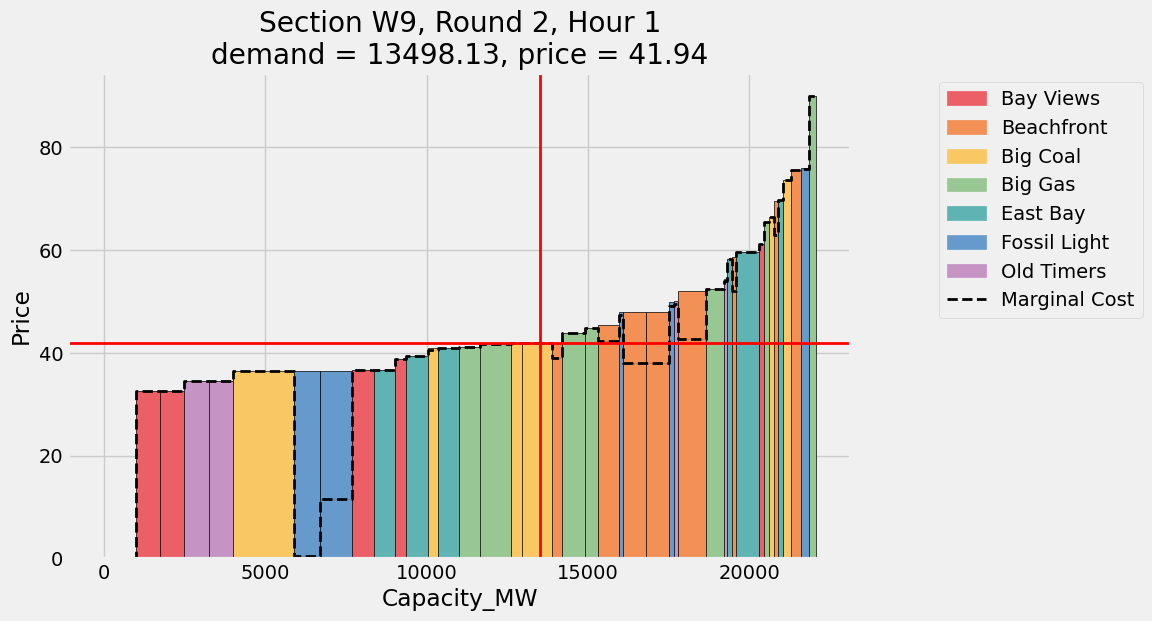

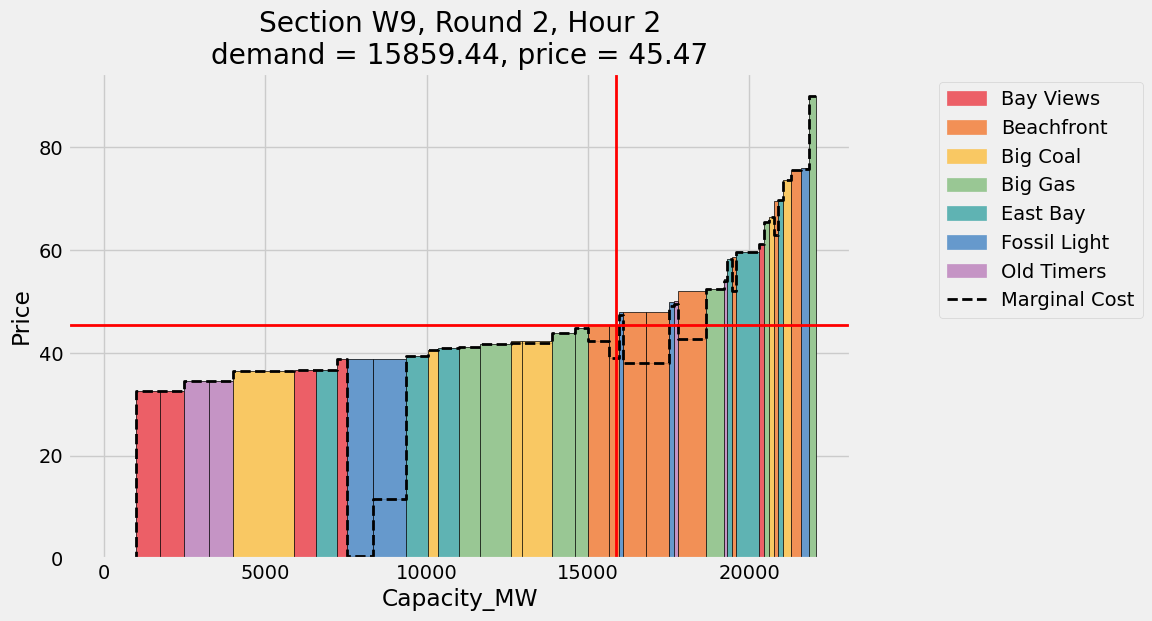

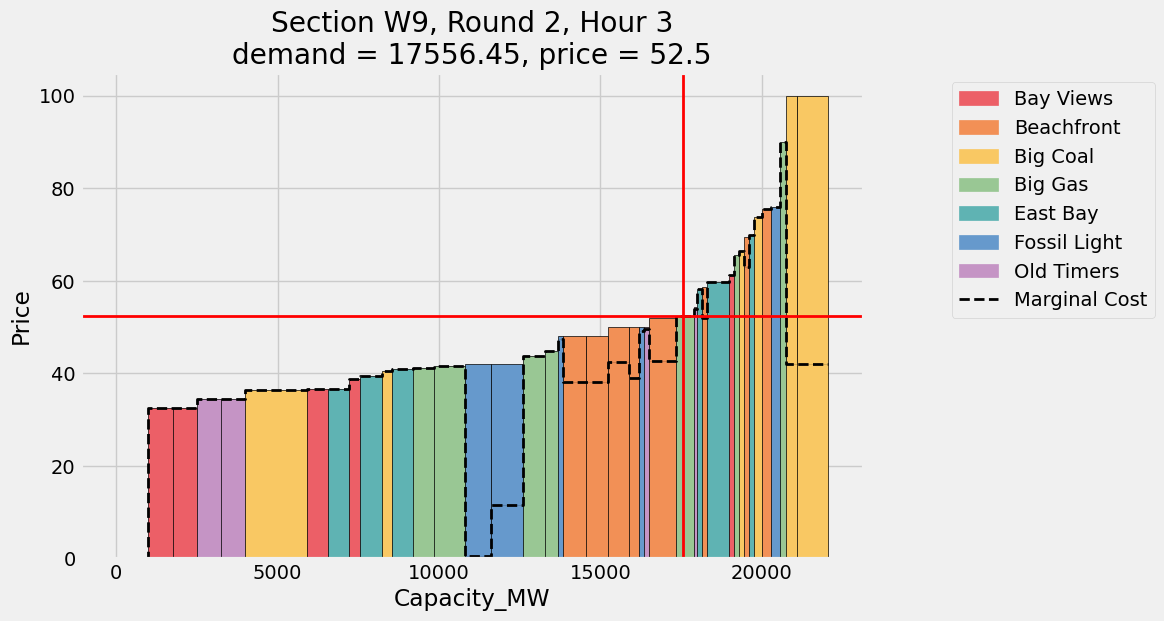

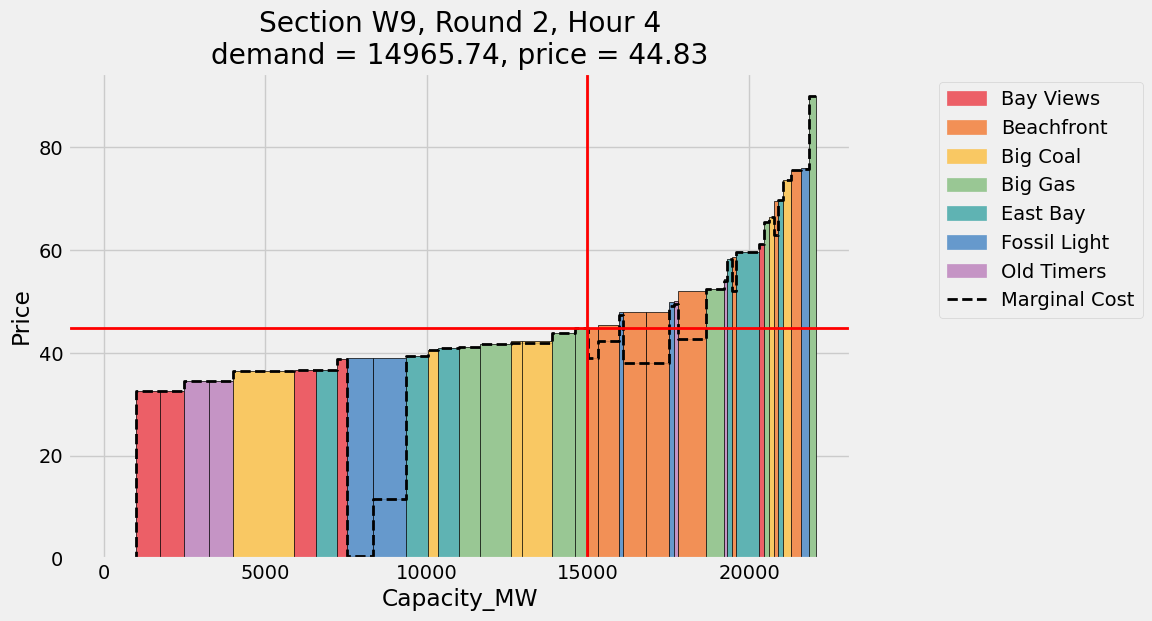

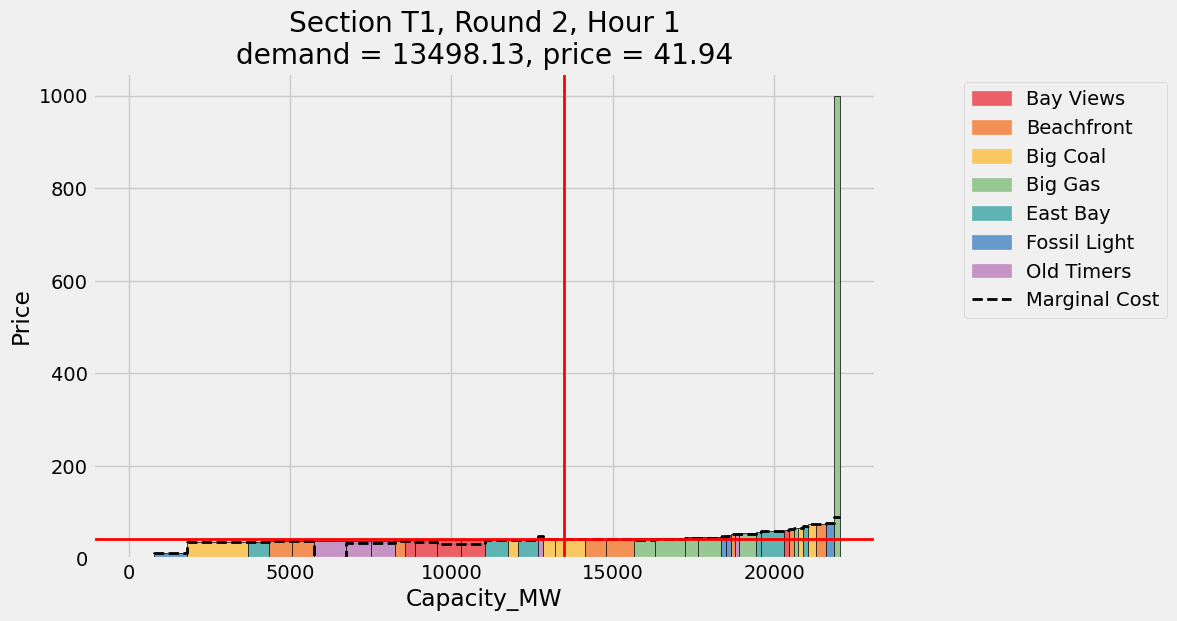

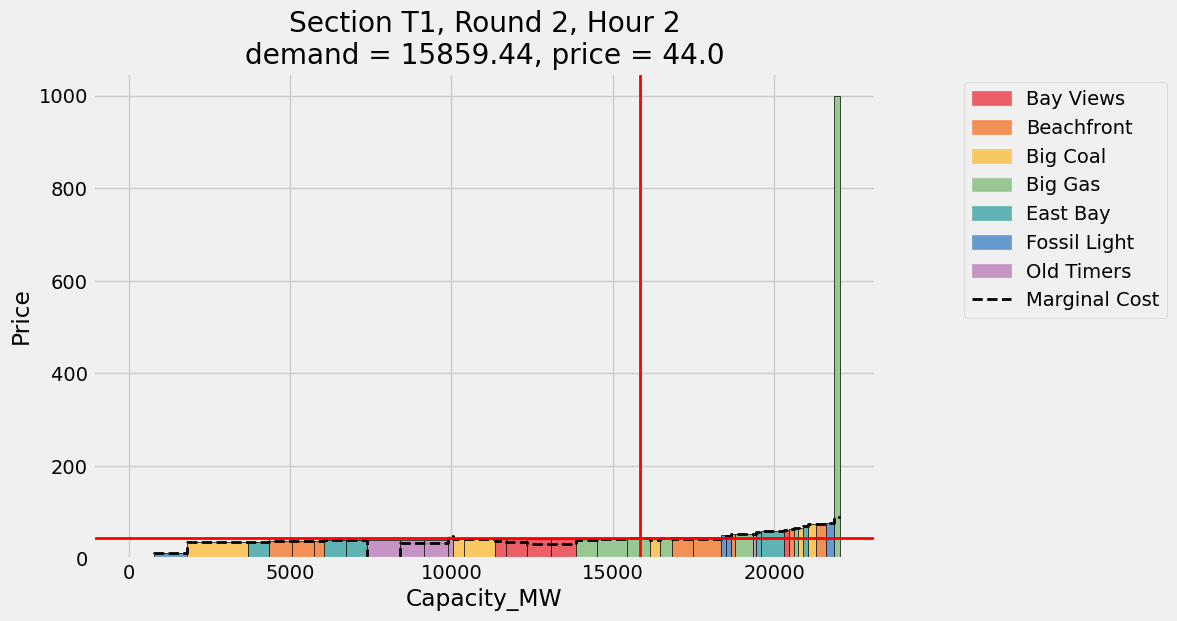

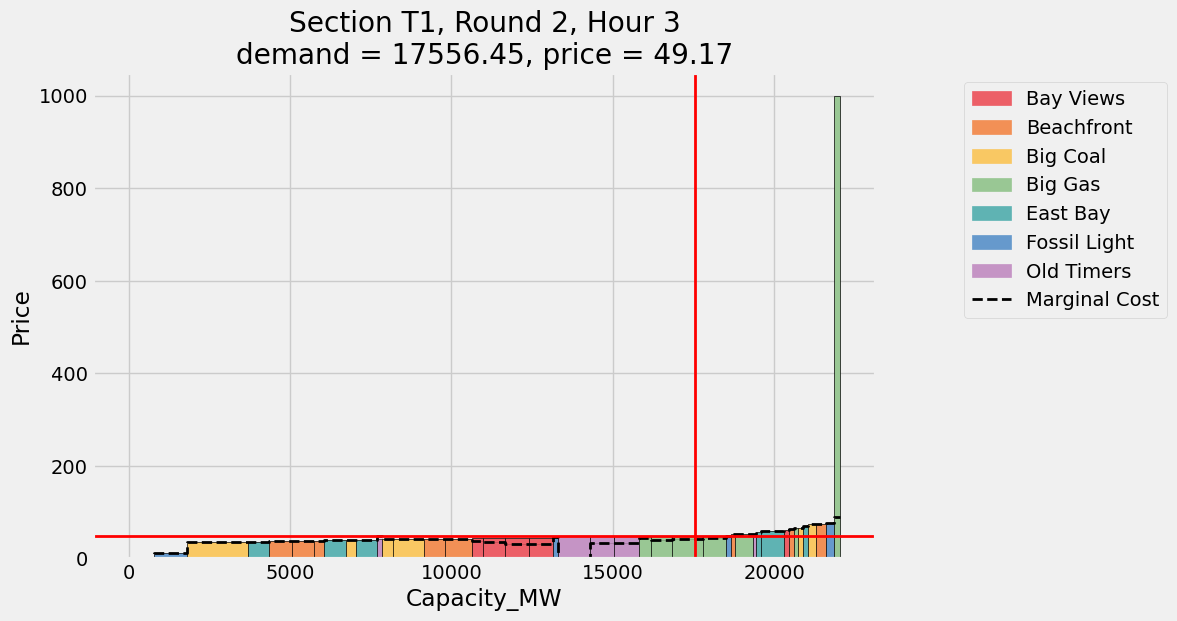

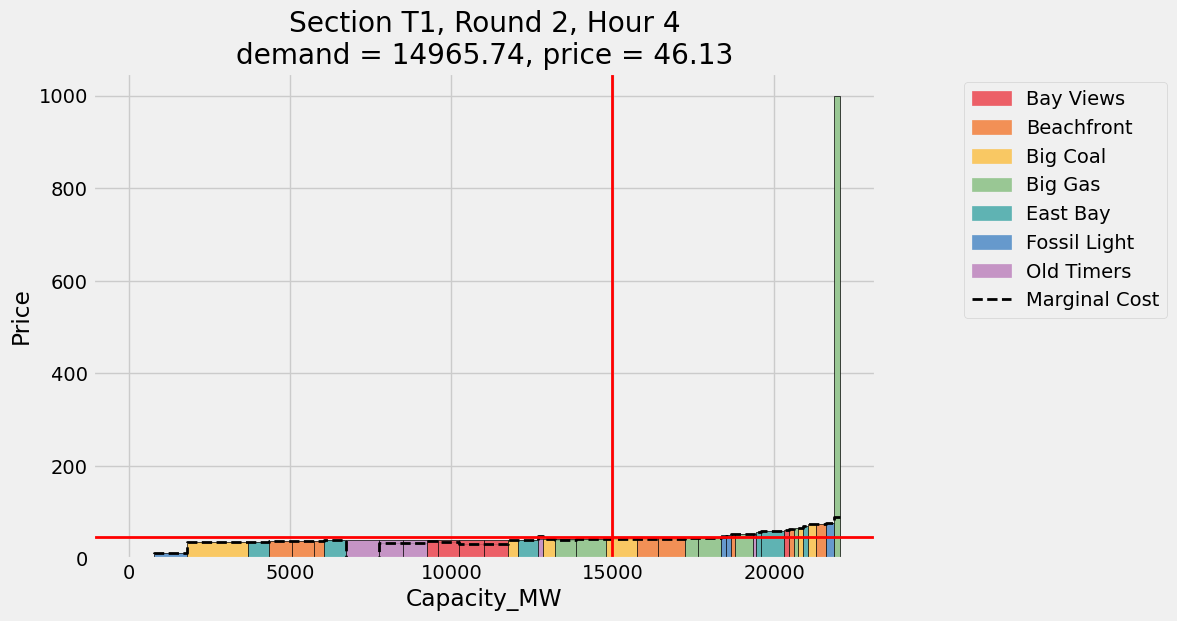

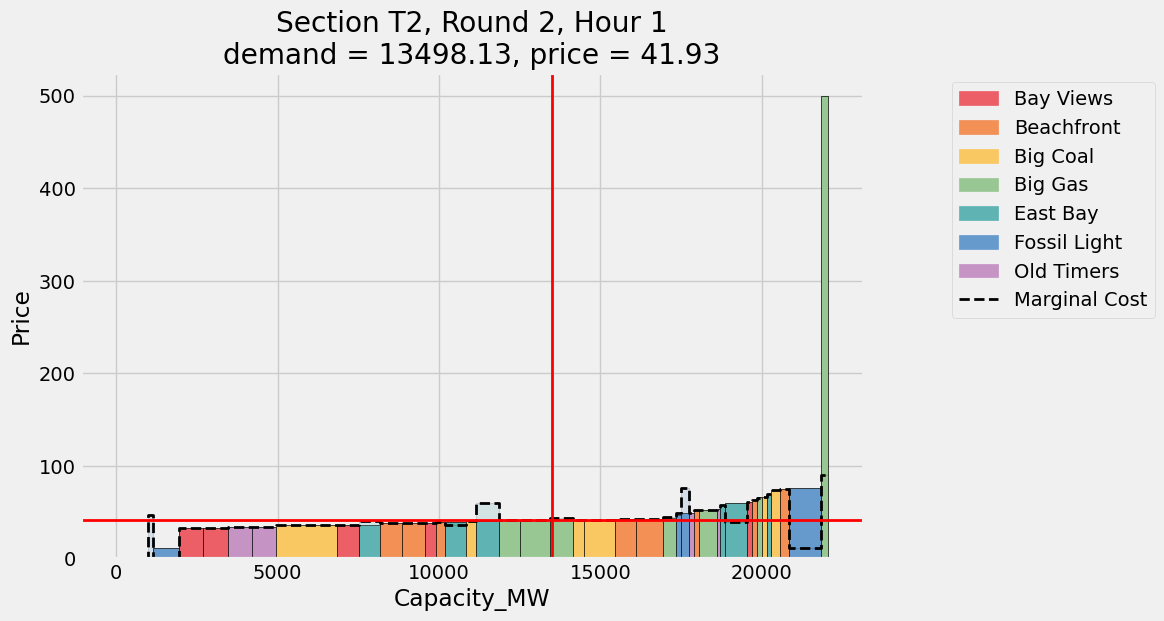

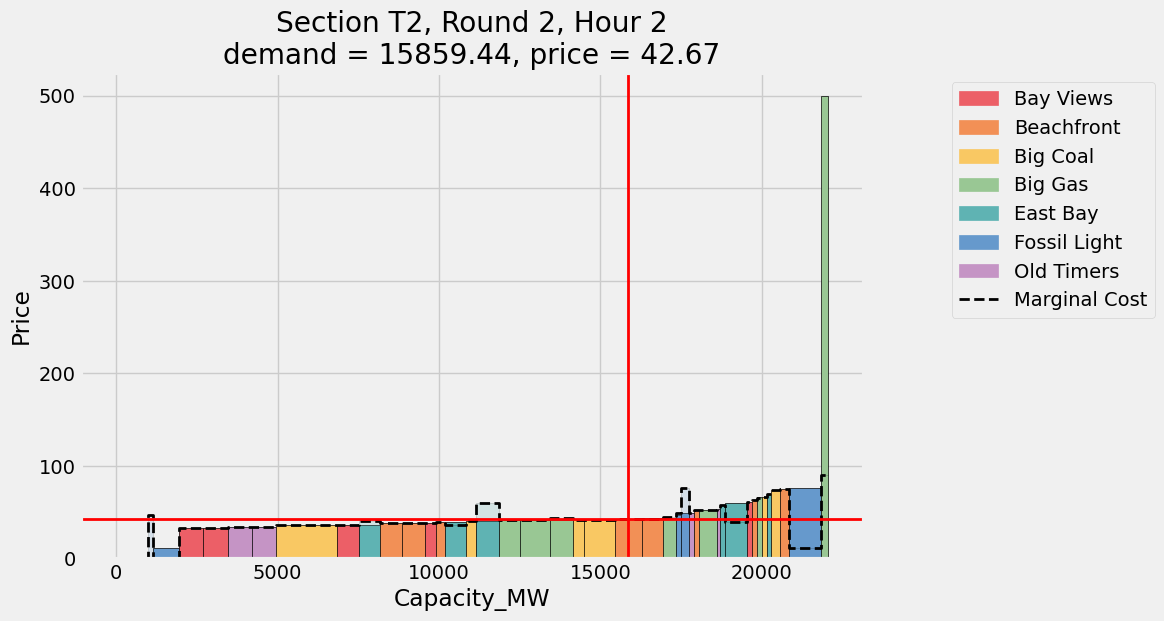

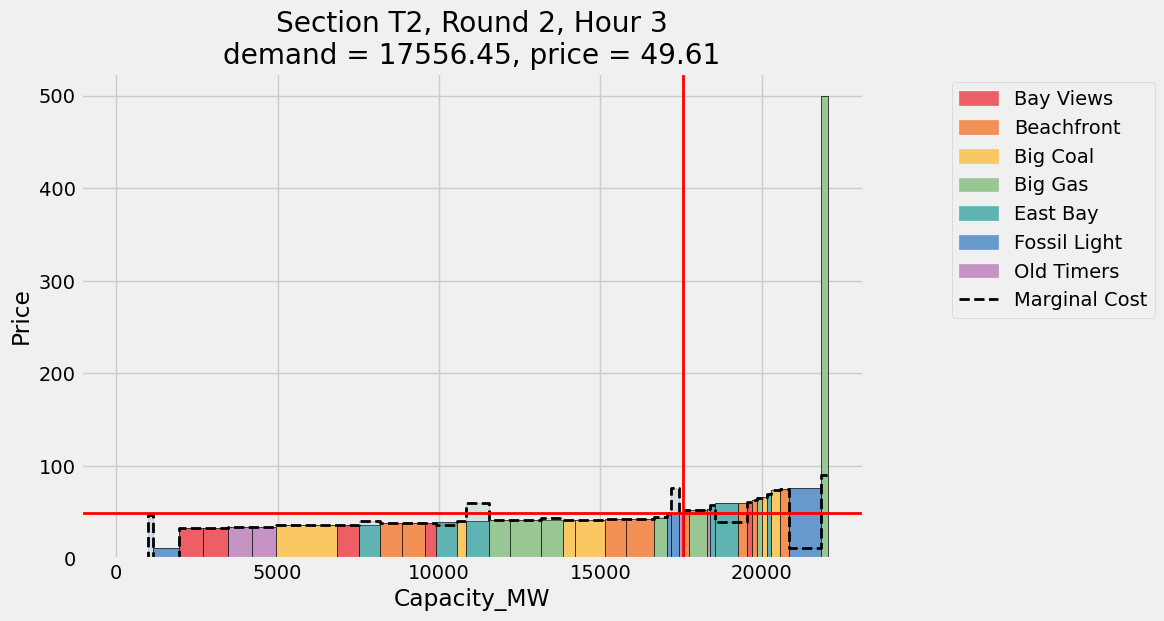

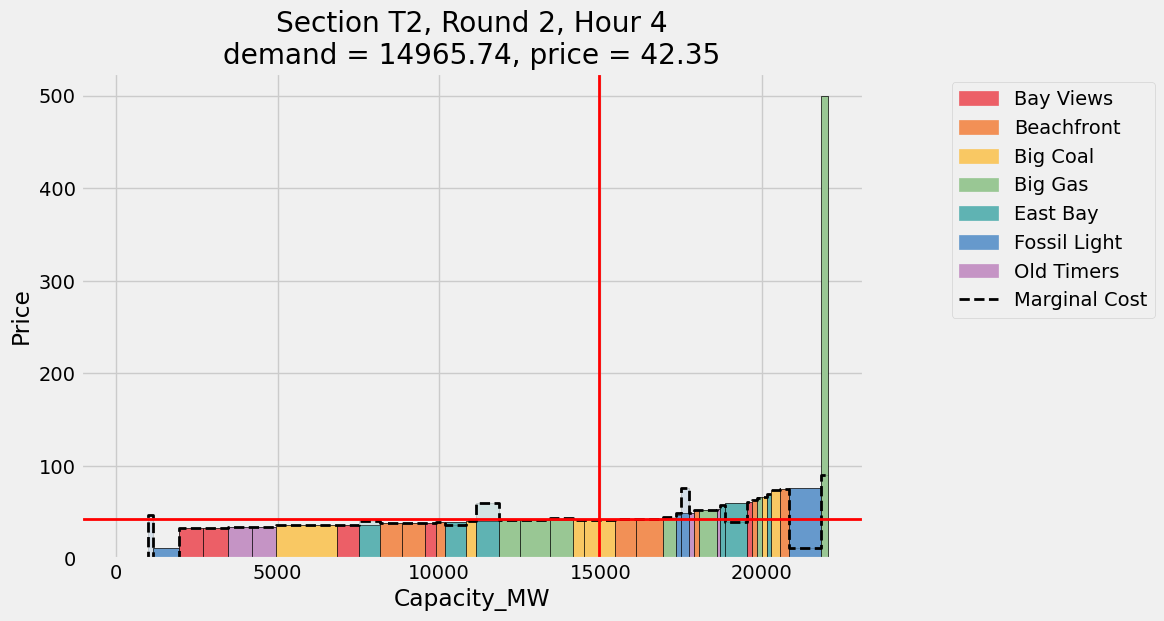

In [35]:
import warnings
warnings.filterwarnings('ignore', category=np.VisibleDeprecationWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)

if period < 7:
    for section in SECTIONS:
        for hour in [1,2,3,4]:
            market_plot(section = section,
                        hour = hour,
                        period = period,
                        carbon_price = 0,
                        my_portfolio = 'Bay Views',
                        def_my_bids = False,
                        def_others_bids = False)
            plt.savefig(section+"_"+str(hour)+".png", bbox_inches="tight")

In [36]:
def permit_plot(period, price_floor, price_ceiling, govt_permits):
    
    auction_bids = pd.read_csv('2023 EEP 147 ESG Permit Auctions (Responses) - Form Responses 1.csv')
    auction_bids = auction_bids[auction_bids['Round'].str.startswith('Round ' + str(period))]
    auction_bids = auction_bids[auction_bids['validbid'] == 'Y']

    buy_order = ['high', 'medium', 'low']
    sell_order = ['low', 'medium', 'high']

    #wide will store p1, q1, p2, q2, and p3, q3 as separate columns
    buy_bids_wide = pd.DataFrame()
    sell_bids_wide = pd.DataFrame()

    #prepare price dataframes
    for price_i in range(1,4):
        buy_bids_wide['p' + str(price_i)] = auction_bids['Buy price ' + str(price_i) + ' (' + str(buy_order[price_i-1]) + ')']
        buy_bids_wide['q' + str(price_i)] = auction_bids['Maximum permits to buy at price ' + str(price_i)]
        sell_bids_wide['p' + str(price_i)] = auction_bids['Sell price ' + str(price_i) + ' (' + str(sell_order[price_i-1]) + ')']
        sell_bids_wide['q' + str(price_i)] = auction_bids['Maximum permits to sell at price ' + str(price_i)]
        if price_i>1:
            for j in range(1, price_i):
                #subtract prior quantities for additional steps (just want step length)
                buy_bids_wide['q' + str(price_i)] = buy_bids_wide['q' + str(price_i)] - buy_bids_wide['q' + str(j)]
                sell_bids_wide['q' + str(price_i)] = sell_bids_wide['q' + str(price_i)] - sell_bids_wide['q' + str(j)]
    #convert to long (just one p and q column)
    buy_bids_wide['id'] = buy_bids_wide.reset_index().index
    buy_bids = pd.wide_to_long(buy_bids_wide, stubnames=['p', 'q'], i='id', j='num').reset_index(drop=True)
    sell_bids_wide['id'] = sell_bids_wide.reset_index().index
    sell_bids = pd.wide_to_long(sell_bids_wide, stubnames=['p', 'q'], i='id', j='num').reset_index(drop=True)
    
    #add government bids to sell bids
    sell_bids = sell_bids.append({'p': price_floor, 'q': govt_permits[period-1]}, ignore_index=True)
    
    #make sure buy bids at 150 >= sell bids at 150
    excess_demand = buy_bids[buy_bids['p'] == price_ceiling]['q'].sum() - sell_bids[sell_bids['p'] <= price_ceiling]['q'].sum()
    if excess_demand > 0:
        sell_bids = sell_bids.append({'p': price_ceiling, 'q': excess_demand}, ignore_index=True)
    
    #collapse each price into a single bid, then sort
    buy_bids = buy_bids.dropna().groupby('p').sum().reset_index().sort_values(by='p', ascending=False)
    sell_bids = sell_bids.dropna().groupby('p').sum().reset_index().sort_values(by='p', ascending=True)
    
    market_df = buy_bids['p'].append(sell_bids['p']).to_frame().sort_values(by='p').drop_duplicates().reset_index(drop=True)
    market_df['bq'] = [buy_bids[buy_bids['p'] >= p]['q'].sum() for p in market_df['p']]
    market_df['sq'] = [sell_bids[sell_bids['p'] <= p]['q'].sum() for p in market_df['p']]
    #get two possible points at which the demand and supply could have intersected.
    price_low = market_df[market_df['bq'] > market_df['sq']]['p'].max()
    price_high = market_df[market_df['bq'] <= market_df['sq']]['p'].min()

    #if the quantities are still not swapped at the middle price, take the higher price
    #this doesn't account for no intersection (will still give the lower price)
    #also does not account for tie with multiple prices and equal quantities
    #will just give the lowest price in the intersection
    #also not yet designed to implement price ceiling
    #(assume Stata code is "right" unless you decide otherwise)
    price_middle = (price_low + price_high)/2
    buy_middle = buy_bids[buy_bids['p'] >= price_middle]['q'].sum()
    sell_middle = sell_bids[sell_bids['p'] <= price_middle]['q'].sum()
    if buy_middle > sell_middle:
        permit_price = price_high
    else:
        permit_price = price_low

    # Make the plot
    plt.figure(figsize=(9,6))

    #add demand line
    num_buy_bids = buy_bids.shape[0]
    x_vec = np.zeros(num_buy_bids * 2)
    h_vec = np.zeros(num_buy_bids * 2)
    for i, (w, h) in enumerate(zip(buy_bids['q'], buy_bids['p'])):
        h_vec[2*i] = h
        h_vec[2*i+1] = h
        if i == 0:
            x_vec[1] = w
        else: 
            x_vec[2*i] = x_vec[2*i - 1]
            x_vec[2*i + 1] = x_vec[2*i] + w    
    h_vec = np.append(h_vec, 0)
    x_vec = np.append(x_vec, x_vec[-1])
    line_demand = plt.plot(x_vec, h_vec, 'b', label='Demand', linewidth=2)

    #add supply line
    num_sell_bids = sell_bids.shape[0]
    x_vec = np.zeros(num_sell_bids * 2)
    h_vec = np.zeros(num_sell_bids * 2)
    for i, (w, h) in enumerate(zip(sell_bids['q'], sell_bids['p'])):
        h_vec[2*i] = h
        h_vec[2*i+1] = h
        if i == 0:
            x_vec[1] = w
        else: 
            x_vec[2*i] = x_vec[2*i - 1]
            x_vec[2*i + 1] = x_vec[2*i] + w
    h_vec = np.insert(h_vec, 0, 0)
    x_vec = np.insert(x_vec, 0, 0)
    line_supply = plt.plot(x_vec, h_vec, 'r', label='Supply', linewidth=2)

    plt.legend(bbox_to_anchor=(1.1,1))

    plt.title('Round ' + str(period) + ' Permit Auction\npermit price = ' + str(round(permit_price,2)))
    plt.xlabel('Permits (tons CO2)')
    plt.ylabel('Price ($ per ton CO2)')
    
if period > 3:
    permit_plot(period, 22, 100, [0, 0, 0, 0, 22640*4, 18288*4, 0])
    plt.savefig("permit_market.png", bbox_inches="tight")

Thanks for help from: Alec Kan, Alma Pineda, Aarish Irfan, Elaine Chien, Octavian Sima, and Eric Van Dusen.